In [1]:
import cv2
import time
import numpy as np
import os, random
import keras.utils.vis_utils as vutil
from IPython.display import SVG
import tensorflow as tf
import keras.models as models
from keras.optimizers import SGD
from imgaug import augmenters as iaa
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import MaxPooling2D, UpSampling2D, Conv2D
from keras.utils import np_utils
from keras.layers import GlobalAveragePooling2D, Input
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
import matplotlib.animation as animation
import sys

%matplotlib nbagg

FRAME_H =  80
FRAME_W = 160

STEER_MIDPT = 1500.
STEER_UPPER = 2000.
STEER_LOWER = 1000.

def draw_steer(image, steer, color, text=''):
    center = (image.shape[1]/2, image.shape[0]/2)
    offset = (image.shape[1]/2 + int(steer*image.shape[1]/2), image.shape[0]/2)
    
    cv2.arrowedLine(image, center, offset, color=color, thickness=1, tipLength=0.4)      
    
    return image

Using TensorFlow backend.


# Preprocessing

In [ ]:
sometime = lambda aug: iaa.Sometimes(0.3, aug)
sequence = iaa.Sequential([ sometime(iaa.GaussianBlur((0, 1.5))), # blur images with a sigma between 0 and 3.0
                            sometime(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), # sharpen images
                            sometime(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3.), per_channel=0.5)), # add gaussian noise to images
                            sometime(iaa.Dropout((0.0, 0.1))), # randomly remove up to 10% of the pixels
                            sometime(iaa.CoarseDropout((0.10, 0.30), size_percent=(0.02, 0.05), per_channel=0.2)),
                            sometime(iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -10 to 10 of original value)
                          ],
                          random_order=True # do all of the above in random order
                         )

def equalize(image):
    norm=np.zeros((image.shape), np.float32)

    norm[:,:,0]=cv2.equalizeHist(image[:,:,0])
    norm[:,:,1]=cv2.equalizeHist(image[:,:,1])
    norm[:,:,2]=cv2.equalizeHist(image[:,:,2])

    return norm

def normalize(image):
    image = image - np.mean(image, axis=(0,1))
    image = image / np.std( image, axis=(0,1))
    
    return image

def augment(image, steer):
    image = sequence.augment_image(image)
    
    if np.random.random() > 0.5:
        shift = np.random.randint(-2,2)
        
        if shift > 0:
            image[-shift:,:,:] = 0
            image[:-shift,:,:] = image[shift:,:,:]
        elif shift < 0:
            image[:-shift,:,:] = 0
            image[-shift:,:,:] = image[:shift,:,:]
    
    if np.random.random() > 0.5:
        image = cv2.flip(image, 1)
        steer = -steer
                
    return image, steer

In [3]:
class BatchGenerator:
    def __init__(self, sessions, batch_size, shuffle = True, terminate = False, jitter = True, norm=True):
        self.images = []
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.terminate = terminate
        self.jitter = jitter
        self.norm = norm

        for session in sessions:
            image_path = session + '/image/'
            label_path = session + '/steer/'

            self.images += sorted([image_path + path for path in os.listdir(image_path)])

        if shuffle: np.random.shuffle(self.images)

    def get_gen(self):
        num_img = len(self.images)
        
        l_bound = 0
        r_bound = self.batch_size if self.batch_size < num_img else num_img    

        while True:
            if l_bound == r_bound:
                if self.terminate:
                    break
                else:
                    l_bound = 0
                    r_bound = self.batch_size if self.batch_size < num_img else num_img
                    if self.shuffle: np.random.shuffle(self.images)

            x_batch = np.zeros((r_bound - l_bound, FRAME_H, FRAME_W, 3))
            y_batch = np.zeros((r_bound - l_bound, 1))
            currt_inst = 0        

            for image_file in self.images[l_bound:r_bound]:
                # construct each input
                image = cv2.imread(image_file)

                # construct each output
                steer = open(image_file.replace('image', 'steer').replace('png', 'txt')).read()
                steer = np.clip(float(steer), STEER_LOWER, STEER_UPPER)
                steer = (float(steer) - STEER_MIDPT) / (STEER_UPPER - STEER_MIDPT)

                if self.jitter: image, steer = augment(image, steer)
                if self.norm:   image = normalize(image)

                x_batch[currt_inst] = image
                y_batch[currt_inst] = steer

                currt_inst += 1
                
            yield x_batch, y_batch

            l_bound = r_bound
            r_bound = r_bound + self.batch_size
            if r_bound > num_img: r_bound = num_img
                
    def get_size(self):
        return len(self.images)

# Construct the network

In [4]:
# Construct the network
image_inp = Input(shape=(FRAME_H, FRAME_W, 3))

x = Conv2D(filters=16, kernel_size=(3, 5), activation='relu', padding='valid')(image_inp)
x = Conv2D(filters=16, kernel_size=(3, 5), activation='relu', padding='valid')(x)
x = MaxPooling2D((4, 2))(x)

x = Conv2D(filters=32, kernel_size=(3, 5), activation='relu', padding='valid')(x)
x = Conv2D(filters=32, kernel_size=(3, 5), activation='relu', padding='valid')(x)
x = MaxPooling2D((4, 2))(x)

x = Conv2D(filters=4,  kernel_size=(1, 1), activation='linear', padding='same')(x)

x = Flatten()(x)

x = Dense(1, activation='tanh', kernel_regularizer='l1')(x)

angle_out = x

model = Model(inputs=[image_inp], outputs=[angle_out])

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 156, 16)       736       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 76, 152, 16)       3856      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 76, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 72, 32)        7712      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 68, 32)        15392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 34, 32)         0         
__________

# Train non-recurrent network

In [384]:
early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, mode='min', verbose=1)
checkpoint  = ModelCheckpoint('weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

batch_num = 32
session_t = ['drive_trial_0', 'drive_trial_2']
session_v = ['drive_trial_1', 'drive_trial_3']

gen_train = BatchGenerator(session_t, batch_num)
gen_valid = BatchGenerator(session_v, batch_num, jitter = False)

num_train = gen_train.get_size()/batch_num
num_valid = gen_valid.get_size()/batch_num

In [7]:
def custom_loss(y_true, y_pred):
    #y_true = tf.Print(y_true, [tf.reduce_mean(y_true - y_pred)], message='DEBUG', summarize=10000) 
    
    # custom loss 1
    #y_pred = tf.clip_by_value(y_pred, -1+1e-7, 1-1e-7)
    #loss = -((1. - y_true) * tf.log(1. - y_pred) + (1. + y_true) * tf.log(1. + y_pred))
    #loss = tf.reduce_mean(loss)
    
    # custom loss 2
    loss = tf.square(y_true - y_pred)
    loss = .5 * tf.reduce_mean(loss)
    
    # custom loss 3
    #loss = tf.abs(y_true - y_pred)
    #loss = tf.reduce_mean(loss)
    
    return loss

In [6]:
model.load_weights('weights.hdf5')

In [ ]:
tb_counter  = max([int(num) for num in os.listdir('../logs/')]) + 1
tensorboard = TensorBoard(log_dir='../logs/' + str(tb_counter), histogram_freq=0, write_graph=True, write_images=False)

minimizer = SGD(lr=0.0001)

#model.compile(loss=custom_loss, optimizer=minimizer)
model.compile(loss=custom_loss, optimizer='adam')

model.fit_generator(generator = gen_train.get_gen(),
                    steps_per_epoch = num_train, 
                    epochs  = 3, 
                    verbose = 1,
                    validation_data = gen_valid.get_gen(), 
                    validation_steps = num_valid, 
                    callbacks = [early_stop, checkpoint, tensorboard], 
                    max_q_size = 3)

In [ ]:
guided_backprop = GuidedBackprop(model, custom_loss=custom_loss)

# Predict stearing angle

In [5]:
from vis.visualization import visualize_regression_cam, overlay

model.load_weights('weights.hdf5')
generator = BatchGenerator(['demo'], 1, shuffle=False, terminate=True, jitter=False, norm=False).get_gen()

<IPython.core.display.Javascript object>


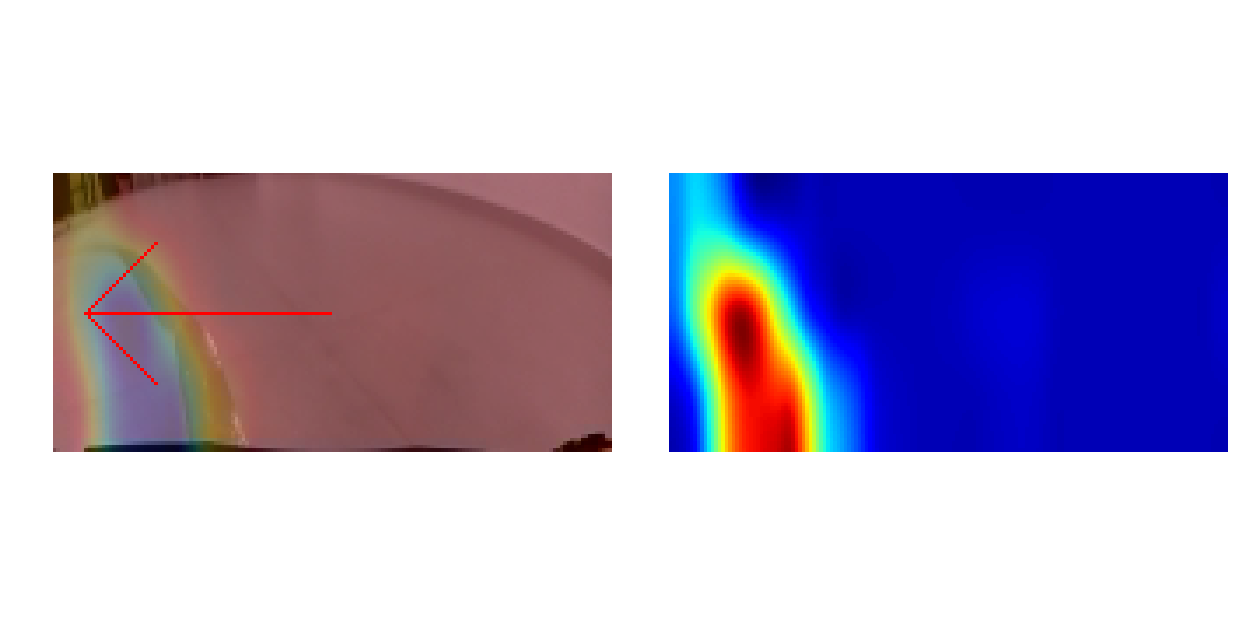

In [6]:
image = generator.next()[0][0]

Writer = animation.writers['ffmpeg']
writer = Writer(fps=8, metadata=dict(artist='Me'), bitrate=1800)

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
image_plot = plt.imshow(image)
plt.axis('off')
plt.subplot(122)
bprop_plot = plt.imshow(image)
plt.axis('off')

pred_time  = 0
pred_count = 0

def updatefig(*args):
    global pred_time, pred_count
    example = generator.next()

    image = example[0][0].astype('uint8').copy()
    steer = example[1][0][0]
    
    mask = visualize_regression_cam(model, -1, [0], [1], normalize(image))
    image = overlay(image, mask, alpha=0.8)
    
    draw_steer(image, steer, (0,0,255))
    
    mask = np.fliplr(mask)
    image = cv2.flip(image, 1).astype('uint8')
    
    image_plot.set_array(image[:,:,::-1])
    bprop_plot.set_array(mask)
    
    return image_plot, mask

plt.tight_layout()
ani = animation.FuncAnimation(fig, updatefig, interval=200, blit=True, save_count=20000) 
#ani.save('demo.mp4', writer=writer)
plt.show()